In [1]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

In [2]:
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor

from ltm.features import load_raster, drop_nan_rows
from ltm.models import EndMemberSplitter

# Define the scoring metrics
scoring = {
    "R2 Score": make_scorer(r2_score),
    "Mean Absolute Error": make_scorer(mean_absolute_error),
    "Root Mean Squared Error": make_scorer(mean_squared_error, squared=False),
}

# Load the data
X = load_raster("../data/processed/composites_X.tif")
y = load_raster("../data/processed/y.tif")

# Drop the NaN columns and rows
X = X.dropna(axis=1)
X, y = drop_nan_rows(X, y)

# Define the model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Define the splitter
splitter = KFold(shuffle=True, random_state=42)
end_member_splitter = EndMemberSplitter(shuffle=True, random_state=42)

# Perform the cross validation
cv_results = cross_validate(
    model, X, y, cv=splitter, scoring=scoring, n_jobs=-1, verbose=1
)
end_member_cv_results = cross_validate(
    model, X, y, cv=end_member_splitter, scoring=scoring, n_jobs=-1, verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


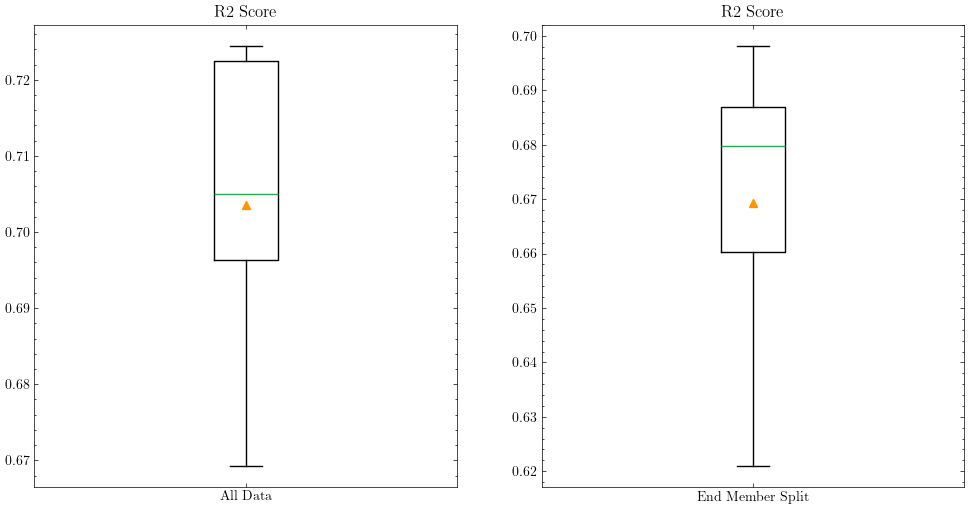

In [3]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].boxplot(cv_results["test_R2 Score"], showmeans=True)
ax[0].set_title("R2 Score")
ax[0].set_xticklabels(["All Data"])

ax[1].boxplot(end_member_cv_results["test_R2 Score"], showmeans=True)
ax[1].set_title("R2 Score")
ax[1].set_xticklabels(["End Member Split"])

plt.show()

In [4]:
import pandas as pd

scores = {key: None for key in cv_results.keys() if key.startswith("test_")}

for score in scores.keys():
    scores[score] = [
        cv_results[score].mean(),
        end_member_cv_results[score].mean(),
    ]

scores = pd.DataFrame(scores, index=["All Data", "End Member Split"])
scores

,test_R2 Score,test_Mean Absolute Error,test_Root Mean Squared Error
All Data,0.703488,0.155520,0.245916
End Member Split,0.669241,0.145602,0.259592


# Base Area Prediction vs. Leaf Type Mixture Prediction

In [5]:
from ltm.models import area2mixture_scorer

X_area = load_raster("../data/processed/composites_X.tif")
y_area = load_raster("../data/processed/y_area.tif")

X_area = X_area.dropna(axis=1)
X_area, y_area = drop_nan_rows(X_area, y_area)

area_scoring = {
    scorer_name: area2mixture_scorer(scorer)
    for scorer_name, scorer in scoring.items()
}

cv_results_area = cross_validate(
    model,
    X_area,
    y_area,
    cv=splitter,
    scoring=area_scoring,
    n_jobs=-1,
    verbose=1,
)
end_member_cv_results_area = cross_validate(
    model,
    X_area,
    y_area,
    cv=end_member_splitter,
    scoring=area_scoring,
    n_jobs=-1,
    verbose=1,
)

scores_area = {
    key: None for key in cv_results_area.keys() if key.startswith("test_")
}
for score in scores_area.keys():
    scores_area[score] = [
        cv_results_area[score].mean(),
        end_member_cv_results_area[score].mean(),
    ]

scores_area = pd.DataFrame(
    scores_area, index=["All Data (Area as Y)", "End Member Split (Area as Y)"]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [15]:
# Add rows of scores_area to scores
pd.concat([scores, scores_area])

,test_R2 Score,test_Mean Absolute Error,test_Root Mean Squared Error
All Data,0.703488,0.155520,0.245916
End Member Split,0.669241,0.145602,0.259592
All Data (Area as Y),0.679048,0.157476,0.255822
End Member Split (Area as Y),0.655007,0.140121,0.265056
